# Racial Differences in Sentencing 

In the United States issues around race have been, and continue to be, an important element of American culture and society. With the adoption of the Civil Rights Act of 1964, legal race-based discrimination is now illegal. However, many economists, sociologists, and political scientists have argued that the legacy of these past policies and practices still negatively affect people in the United States today. 

Policy makers who wish to address these programs need to understand the extent of these issues so they can properly implement new or revise current laws. This notebook uses data from Cook County, IL and basic econometric tools to determine the extent of racial bias in prison sentence length for Black and White Americans. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import_df = pd.read_csv('sentencing.csv', dtype={'DISPOSITION_CHARGED_CHAPTER':'str','DISPOSITION_CHARGED_ACT':'str',
                                                'DISPOSITION_CHARGED_AOIC':'str','COMMITMENT_TERM':'object'})

In [3]:
sentencing_df = import_df.copy(deep=True)
sentencing_df.shape

(265706, 41)

In [4]:
sentencing_df.head(3)

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,INCIDENT_CITY,INCIDENT_BEGIN_DATE,INCIDENT_END_DATE,LAW_ENFORCEMENT_AGENCY,LAW_ENFORCEMENT_UNIT,ARREST_DATE,FELONY_REVIEW_DATE,FELONY_REVIEW_RESULT,ARRAIGNMENT_DATE,UPDATED_OFFENSE_CATEGORY
0,2.263280e+11,8.314865e+10,2/5/2002 0:00,PROMIS Conversion,True,6.238910e+12,1.097000e+12,CONSPIRACY TO COMMIT FIRST DEGREE MURDER,1,6/17/2019 0:00,...,NaN,7/2/2000 0:00,NaN,CHICAGO POLICE DEPT,NaN,10/8/2016 20:00,10/9/2016 0:00,Approved,11/7/2016 0:00,PROMIS Conversion
1,2.454920e+11,8.979522e+10,12/6/2004 0:00,PROMIS Conversion,True,1.811430e+12,3.578730e+11,MFG/DEL CONTROLLED SUBSTANCE,1,9/8/2011 0:00,...,NaN,8/4/2004 0:00,NaN,NARC ORG CRIME DIVSN - UNIT 91,NaN,10/15/2010 9:05,NaN,NaN,9/9/2010 0:00,PROMIS Conversion
2,2.470270e+11,9.178907e+10,5/11/2005 0:00,PROMIS Conversion,True,1.959610e+12,2.215030e+11,DUI LIC SUSPENDED OR REVOKED (EFFECTIVE 4-13-2...,1,9/24/2013 0:00,...,NaN,4/9/2005 0:00,4/9/2005 0:00,C P D AREA 4 DIST 10,NaN,4/9/2005 2:35,5/11/2005 0:00,Sf,NaN,PROMIS Conversion


## Filtering Down to Desired Defendants
For this notebook, we will limit our focus to only Black and White Americans between the ages of 18 and 39, who were arrested between 2010 and 2019 for a felony narcotics charge, and were sentenced to some time in prison. This is to allow us to compare a mostly similar group of individuals to each other.

In [5]:
sentencing_df.columns

Index(['CASE_ID', 'CASE_PARTICIPANT_ID', 'RECEIVED_DATE', 'OFFENSE_CATEGORY',
       'PRIMARY_CHARGE_FLAG', 'CHARGE_ID', 'CHARGE_VERSION_ID',
       'DISPOSITION_CHARGED_OFFENSE_TITLE', 'CHARGE_COUNT', 'DISPOSITION_DATE',
       'DISPOSITION_CHARGED_CHAPTER', 'DISPOSITION_CHARGED_ACT',
       'DISPOSITION_CHARGED_SECTION', 'DISPOSITION_CHARGED_CLASS',
       'DISPOSITION_CHARGED_AOIC', 'CHARGE_DISPOSITION',
       'CHARGE_DISPOSITION_REASON', 'SENTENCE_JUDGE', 'SENTENCE_COURT_NAME',
       'SENTENCE_COURT_FACILITY', 'SENTENCE_PHASE', 'SENTENCE_DATE',
       'SENTENCE_TYPE', 'CURRENT_SENTENCE_FLAG', 'COMMITMENT_TYPE',
       'COMMITMENT_TERM', 'COMMITMENT_UNIT', 'LENGTH_OF_CASE_in_Days',
       'AGE_AT_INCIDENT', 'RACE', 'GENDER', 'INCIDENT_CITY',
       'INCIDENT_BEGIN_DATE', 'INCIDENT_END_DATE', 'LAW_ENFORCEMENT_AGENCY',
       'LAW_ENFORCEMENT_UNIT', 'ARREST_DATE', 'FELONY_REVIEW_DATE',
       'FELONY_REVIEW_RESULT', 'ARRAIGNMENT_DATE', 'UPDATED_OFFENSE_CATEGORY'],
      dtype='objec

In [6]:
# filtering dataframe to only keep cases related to narcotics 
sentencing_df = sentencing_df[sentencing_df['UPDATED_OFFENSE_CATEGORY'] == 'Narcotics']

In [7]:
# changing the ARREST_DATE variable to datetime from string to allow filtering by date
sentencing_df['ARREST_DATE'] = pd.to_datetime(sentencing_df['ARREST_DATE'])

# filtering the dataframe to only have 
sentencing_df = sentencing_df[sentencing_df['ARREST_DATE'].between('2010-01-01', '2019-12-31')]

In [8]:
# filtering dataframe to only have defendants between ages getting ages between 18 and 39
sentencing_df = sentencing_df[sentencing_df['AGE_AT_INCIDENT'].between(18, 39)]

In [9]:
# main variables to be used, dropping na values 
keep_list = ['CHARGE_COUNT','AGE_AT_INCIDENT','RACE','GENDER', 'COMMITMENT_TERM',
             'COMMITMENT_UNIT','DISPOSITION_CHARGED_CLASS','SENTENCE_TYPE']

sentencing_df = sentencing_df.dropna(subset=keep_list)

In [10]:
# filtering dataset for only felony crimes
felony_list = ['X', '1', '2', '3', '4']
sentencing_df = sentencing_df[sentencing_df['DISPOSITION_CHARGED_CLASS'].isin(felony_list)]

In [11]:
# filtering for only instances where the the defendent was sentanced to prison 
sentencing_df = sentencing_df[sentencing_df['SENTENCE_TYPE'] == 'Prison']

In [12]:
# updating commitment term to numeric 
sentencing_df['COMMITMENT_TERM'] = sentencing_df['COMMITMENT_TERM'].astype('float')

In [13]:
# filtering dataframe to only include commitment units in years, months, or days 
sentencing_df = sentencing_df[
    (sentencing_df['COMMITMENT_UNIT']=='Year(s)') | 
    (sentencing_df['COMMITMENT_UNIT']=='Months') | 
    (sentencing_df['COMMITMENT_UNIT']=='Days')]

# removing 0 from commitmnet term 
sentencing_df = sentencing_df[sentencing_df['COMMITMENT_TERM'] != 0]

In [14]:
# filtering dataframe to remove unknown gender
sentencing_df = sentencing_df[
    (sentencing_df['GENDER']=='Female') | 
    (sentencing_df['GENDER']=='Male')]

sentencing_df['GENDER'] = sentencing_df['GENDER'].str.upper()

## Creating New Variables
In order to aid the the contruction of the regression analysis, I will create a few new variables that capture important information about the defenants. 
1. DISPOSITION_TYPE: A binary variable indicating whether the defenant plead guilty or if a judge/jury found them guilty
2. TERM_IN_MONTHS: An update of the commitment variable where the duration of each sentence is converted into months rather than different units of years, months, and days 
3. RACE_UPDATED: An update of the RACE variable that properly classifies Black and White individuals and classifies other races as "Other"

In addition to the three mentioned above, a log transformation will be taken for all continuous variables to allow percentage comparison to be estimated. 


In [15]:
# creating variable for whether the defendant plead guily or was found guilty

DISPOSITION_TYPE = []

for index, row in sentencing_df.iterrows():
    if row['CHARGE_DISPOSITION'] == 'Plea Of Guilty':
        DISPOSITION_TYPE.append('PLEAD_GUILTY')
    elif row['CHARGE_DISPOSITION'] == 'Finding Guilty' or 'Verdict Guilty':
        DISPOSITION_TYPE.append('FOUND_GUILTY')
    else:
        DISPOSITION_TYPE.append('OTHER')


sentencing_df['DISPOSITION_TYPE'] = DISPOSITION_TYPE  

# filtering for only guilty verdicts
sentencing_df = sentencing_df[sentencing_df['DISPOSITION_TYPE'] != 'OTHER']

In [16]:
# creating a new column to standardize sentence duration to around months
SENTENCE_TERM = []

for index, row in sentencing_df.iterrows():
    if row['COMMITMENT_UNIT'] == 'Year(s)':
        SENTENCE_TERM.append(row['COMMITMENT_TERM']/12)
        
    elif row['COMMITMENT_UNIT'] == 'Months':
        SENTENCE_TERM.append(row['COMMITMENT_TERM']/1)
        
    elif row['COMMITMENT_UNIT'] == 'Days':
        SENTENCE_TERM.append(row['COMMITMENT_TERM']/30)
        
sentencing_df['SENTENCE_TERM'] = np.round(SENTENCE_TERM, 3) 

In [17]:
# updating race to remove unknown and classifying race - black, white

RACE_UPDATED = []

for index, row in sentencing_df.iterrows():
    if 'Black' in row['RACE']:
        RACE_UPDATED.append('BLACK')
    elif row['RACE'] == 'White':
        RACE_UPDATED.append('WHITE')
    else:
        RACE_UPDATED.append('OTHER')

sentencing_df['RACE'] = RACE_UPDATED


# filtering dataframe to only include Black and White individuals 
sentencing_df = sentencing_df[sentencing_df['RACE'] != 'OTHER']

In [18]:
# filtering to only usable features 
feature_list = ['CHARGE_COUNT','AGE_AT_INCIDENT','RACE','GENDER',
                'SENTENCE_TERM','DISPOSITION_TYPE']

regression_df = sentencing_df[feature_list].copy(deep=True)

In [19]:
# log transformation for all continuous variables 
regression_df['CHARGE_COUNT_LOG'] = np.log(sentencing_df['CHARGE_COUNT'])
regression_df['AGE_AT_INCIDENT_LOG'] = np.log(sentencing_df['AGE_AT_INCIDENT'])
regression_df['SENTENCE_TERM_LOG'] = np.log(sentencing_df['SENTENCE_TERM'])

## Visualizing the Dataset

The visualizations below mostly confirm the expectations of the dataset. The two box plots show that Black defendants are more likely to be sentenced to longer terms compared to White defendants and that males are more likely to serve longer than females, even accounting for extreme outliers. 

We can also see that the vast majority of defendants plead guilty to there cases. A trend that is often noted in discussions of criminal justice reform.

The correlation heatmap displays weaker correlations between the Charge Count, Age at Incident, and Sentence Term variables than expected.

In [20]:
regression_df.columns

Index(['CHARGE_COUNT', 'AGE_AT_INCIDENT', 'RACE', 'GENDER', 'SENTENCE_TERM',
       'DISPOSITION_TYPE', 'CHARGE_COUNT_LOG', 'AGE_AT_INCIDENT_LOG',
       'SENTENCE_TERM_LOG'],
      dtype='object')

In [21]:
regression_df.describe()

,CHARGE_COUNT,AGE_AT_INCIDENT,SENTENCE_TERM,CHARGE_COUNT_LOG,AGE_AT_INCIDENT_LOG,SENTENCE_TERM_LOG
count,18485.000000,18485.000000,18485.000000,18485.000000,18485.000000,18485.000000
mean,1.512794,27.584853,3.636059,0.269527,3.295000,-1.020910
std,1.377357,5.809397,10.093980,0.458561,0.211610,1.762894
min,1.000000,18.000000,0.067000,0.000000,2.890372,-2.703063
25%,1.000000,23.000000,0.083000,0.000000,3.135494,-2.488915
50%,1.000000,27.000000,0.250000,0.000000,3.295837,-1.386294
75%,2.000000,32.000000,0.417000,0.693147,3.465736,-0.874669
max,46.000000,39.000000,216.000000,3.828641,3.663562,5.375278


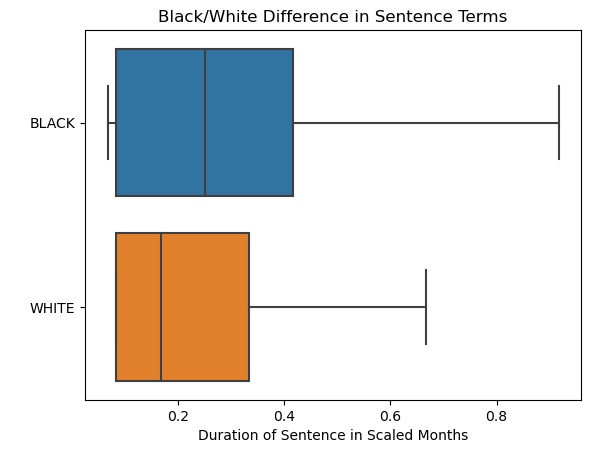

In [22]:
sns.boxplot(data=regression_df, x="SENTENCE_TERM", y="RACE",showfliers=False)

plt.xlabel('Duration of Sentence in Scaled Months')
plt.ylabel(' ')
plt.title('Black/White Difference in Sentence Terms')

plt.show()

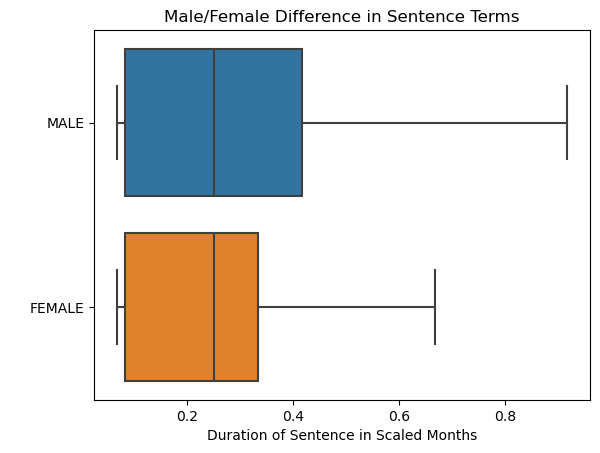

In [23]:
sns.boxplot(data=regression_df, x="SENTENCE_TERM", y="GENDER", showfliers=False)

plt.xlabel('Duration of Sentence in Scaled Months')
plt.ylabel(' ')
plt.title('Male/Female Difference in Sentence Terms')

plt.show()

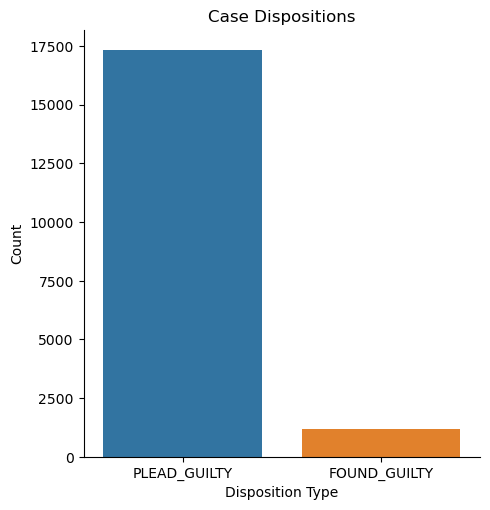

In [24]:
sns.catplot(data=regression_df, x="DISPOSITION_TYPE", kind='count')
plt.ylabel('Count')
plt.xlabel('Disposition Type')
plt.title('Case Dispositions')
plt.show()

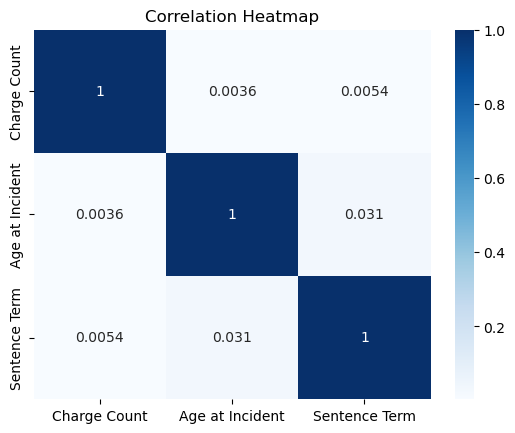

In [25]:
corr = sentencing_df[['CHARGE_COUNT', 'AGE_AT_INCIDENT','SENTENCE_TERM']].corr()

sns.heatmap(corr, cmap="Blues", annot=True, 
            xticklabels=['Charge Count','Age at Incident','Sentence Term'],
            yticklabels=['Charge Count','Age at Incident','Sentence Term'])
plt.title('Correlation Heatmap')
plt.show()

## Performing the Regressions

In [26]:
# getting binary numeric form for all categorical variables 
regression_df = pd.get_dummies(regression_df)
regression_df.head(3)

,CHARGE_COUNT,AGE_AT_INCIDENT,SENTENCE_TERM,CHARGE_COUNT_LOG,AGE_AT_INCIDENT_LOG,SENTENCE_TERM_LOG,RACE_BLACK,RACE_WHITE,GENDER_FEMALE,GENDER_MALE,DISPOSITION_TYPE_FOUND_GUILTY,DISPOSITION_TYPE_PLEAD_GUILTY
10065,1,27.0,0.333,0.000000,3.295837,-1.099613,1,0,0,1,0,1
10092,2,22.0,0.417,0.693147,3.091042,-0.874669,1,0,0,1,0,1
10110,1,27.0,0.083,0.000000,3.295837,-2.488915,1,0,0,1,0,1


In [27]:
regression_df.shape

(18485, 12)

In [28]:
# definning the two dependent variables to be used 
y = regression_df['SENTENCE_TERM']
y_log = regression_df['SENTENCE_TERM_LOG']

### Regression One

Below, we see the first regression relating the sentence term variable to the race, gender, number of charges, age at incident, and disposition type variables. From the output, we can see that all the independent variables, except for gender, appear to be statistically significant at the five percent level. 

The main variable of concern here, RACE_BLACK, is statistically significant and has a coefficient of 0.8850, indicating that a Black defendant is expected to spend about three more weeks in prison than a White defendant. 

In [29]:
#defining the first set of independant variables 
x_1 = regression_df[['RACE_BLACK','GENDER_FEMALE','CHARGE_COUNT','DISPOSITION_TYPE_PLEAD_GUILTY','AGE_AT_INCIDENT',]]
x_1 = sm.add_constant(x_1)

In [30]:
# fitting the model and printing the output
model_1 = sm.OLS(y, x_1).fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:          SENTENCE_TERM   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     18.29
Date:                Mon, 10 Oct 2022   Prob (F-statistic):           3.66e-18
Time:                        11:32:03   Log-Likelihood:                -68919.
No. Observations:               18485   AIC:                         1.379e+05
Df Residuals:                   18479   BIC:                         1.379e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### Regression Two

The second regression uses the same independent variables as the first, but also uses the log form of the sentence term variable as the dependent variable. Here we can see that once again all the independent variables are statistically significant at the five percent level.

In [31]:
#defining the second set of independant variables 
x_2 = regression_df[['RACE_BLACK','GENDER_FEMALE','CHARGE_COUNT','DISPOSITION_TYPE_PLEAD_GUILTY','AGE_AT_INCIDENT']]
x_2 = sm.add_constant(x_2)

In [32]:
model_2 = sm.OLS(y_log, x_2).fit()
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:      SENTENCE_TERM_LOG   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     37.54
Date:                Mon, 10 Oct 2022   Prob (F-statistic):           1.93e-38
Time:                        11:32:03   Log-Likelihood:                -36615.
No. Observations:               18485   AIC:                         7.324e+04
Df Residuals:                   18479   BIC:                         7.329e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### Regression Three

In the final regression, the log version of the sentence term variable is used as well as the log versions of Charge Count and Age at Incident. Here we can see that if the defendant is Black, they are expected to spend about twenty-five percent more time in prison than if they were White. 

In [33]:
#defining the third set of independant variables 
x_3 = regression_df[['RACE_BLACK','GENDER_FEMALE','CHARGE_COUNT_LOG','DISPOSITION_TYPE_PLEAD_GUILTY','AGE_AT_INCIDENT_LOG']]
x_3 = sm.add_constant(x_3)

In [34]:
model_3 = sm.OLS(y_log, x_3).fit()
print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:      SENTENCE_TERM_LOG   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     40.29
Date:                Mon, 10 Oct 2022   Prob (F-statistic):           2.36e-41
Time:                        11:32:03   Log-Likelihood:                -36609.
No. Observations:               18485   AIC:                         7.323e+04
Df Residuals:                   18479   BIC:                         7.328e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

## Conclusion

Altogether, there does appear to be a relationship between the race of the defendant and the amount of time they are sentenced to prison. Policy makers who wish to address this arbitrary disparity between White and Black defendants will need to create stricter guidelines determining how a defendant in sentenced, allowing less room for arbitrary judgment in sentencing. 